# Fig3-Analysis of Ecdysone Receptor nuclear concentration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from glob import glob
from scipy.stats import zscore
from matplotlib import rc
import matplotlib as mpl

In [9]:
%matplotlib qt

In [2]:
rc('axes', linewidth=4)
linewidth=4
fontsize=24

colors = ((27,158,119),
          (217,95,2),
          (117,112,179),
          (231,41,138),
          (102,166,30),
          (230,171,2))

def style_axes(ax, fontsize=24):
    plt.minorticks_off()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    plt.tight_layout()
    
    return ax

In [3]:
def bin_aps(df, bins, ap_col='y'):
    _counts, bins = np.histogram(df.get(ap_col), bins)
    bins = bins[1:]
    partial_func = partial(get_ap_bin, bins=bins)
    binned_aps = df.get(ap_col).apply(partial_func)
    df[f'binned_{ap_col}'] = binned_aps.values
    
    return df
    

def get_ap_bin(this_ap, bins):
    this_bin = np.where(np.abs(this_ap - bins) == np.nanmin(np.abs(this_ap - bins)))[0][0]

    return this_bin
    



In [4]:
experiment_paths = [
    r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2024_02_06_ca-Gal4_UAS-His-RFP_mNG-EcR-B1']

quant_col = 'ch0'
method = 'bkg_sub_mean_ch0'
#method = 'raw_mean_ch0'

df_name = 'nuclei_3_quant_v4_bkg_by_slice.pkl'

<AxesSubplot:xlabel='fraction of anterior-posterior axis', ylabel='mean EcR-B1 \nfluorescence intensity (a.u.)'>

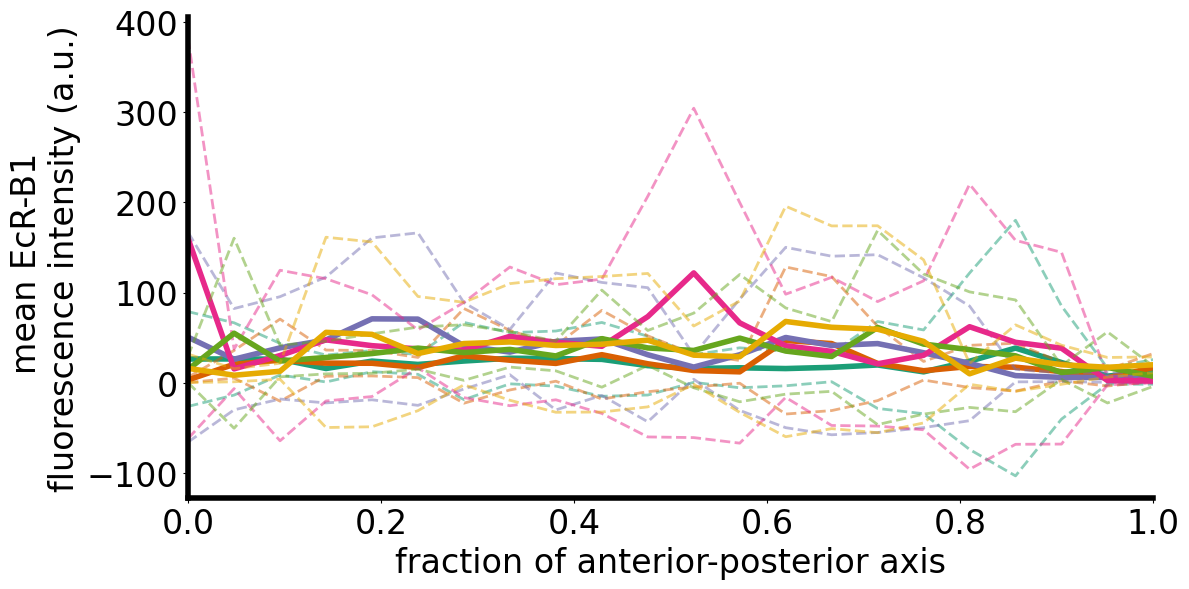

In [5]:
n_bins = 22
all_means = np.zeros((6, n_bins))
all_stds = np.zeros((6, n_bins))
bins = np.linspace(0, 1, n_bins + 1)
ap_col = 'ap'
counter= 0
q95 = np.zeros(6)
plt.figure(figsize=(12, 6))
for path in experiment_paths:
    larvae_dirs = glob(path + '/larva*')
    for larvae_dir in larvae_dirs:
        if larvae_dir == r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2024_02_06_ca-Gal4_UAS-His-RFP_mNG-EcR-B1/larva_1':
            continue
        df = pd.read_pickle(larvae_dir + '/' + df_name)

    
        df['ap'] = df.y / df.y.max()
        df = bin_aps(df, bins, ap_col='ap')

        binned_means = df.get([method, f'binned_{ap_col}']).groupby(by=f'binned_{ap_col}').mean().values.flatten()
        binned_std = df.get([method, f'binned_{ap_col}']).groupby(by=f'binned_{ap_col}').std().values.flatten()
        
        m = binned_means
        s = binned_std
        l = m -s
        u = m + s
        ap = bins[:-1] / np.max(bins[:-1])
        plt.plot(ap, m, color=np.array(colors[counter]) / 255, linewidth=4)
        plt.plot(ap, l, '--', color=np.array(colors[counter]) / 255, linewidth=2, alpha=0.5)
        plt.plot(ap, u, '--', color=np.array(colors[counter]) / 255, linewidth=2, alpha=0.5)

        all_means[counter] = binned_means
        all_stds[counter] = binned_std
        q95[counter] = np.quantile(df.get(method), 0.95)

        counter += 1
        
plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel('mean EcR-B1 \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.xlim([0, 1])
style_axes(plt.gca())






In [10]:
color=(0, 150 / 255, 150 / 255)

plt.figure(figsize=(13, 5.5))

mean_q95 = np.mean(q95)
m = np.mean(all_means, axis=0)
s = np.sqrt(np.mean(all_stds ** 2, axis=0) / len(all_stds))
l = m -s
u = m + s
plt.plot(bins[:-1] / np.max(bins[:-1]), m, color=color, linewidth=4, label='mean')
plt.fill_between(bins[:-1] / np.max(bins[:-1]), l, u, facecolor=color, alpha=0.3, label='_nolabel_')
plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel('mean mNG-EcR-B1 \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.xlim([0, 1])
style_axes(plt.gca())


<AxesSubplot:xlabel='fraction of anterior-posterior axis', ylabel='mean mNG-EcR-B1 \nfluorescence intensity (a.u.)'>

In [11]:
plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig3-Ecr/ecr_ap_dist_shaded_errorbar.pdf')